In [37]:
# import library and load dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

In [38]:
# load dataset
data_path = '../../data/processed/data_cleaned_scaled_onehot.csv' 
data = pd.read_csv(data_path)

# form features and target
X = data.drop(['Target'], axis=1)
y = data['Target']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Adjust the class distribution to ensure the model learns adequately about the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [39]:
# hyper parameter search for k-NN classifier
param_grid = {
    'n_neighbors': range(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=10)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
best_k = grid_search.best_params_['n_neighbors']

{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.8400737824298586


In [40]:
# cross validation to evaluate model consistently
knn = KNeighborsClassifier(n_neighbors=best_k, weights='uniform', metric='euclidean')
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='recall')

print("recall mean:", scores.mean(), "recall std:", scores.std())

recall mean: 0.579115479115479 recall std: 0.03467930322876949


In [41]:
# compare results with unscaled data
knn = KNeighborsClassifier(n_neighbors=best_k, weights='uniform', metric='euclidean')
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='recall')

print("recall mean:", scores.mean(), "recall std:", scores.std())

recall mean: 0.579115479115479 recall std: 0.03467930322876949


In [42]:
# using K-NN to predict the target
knn = KNeighborsClassifier(n_neighbors=best_k, weights='uniform', metric='euclidean')
knn.fit(X_train_resampled, y_train_resampled)
y_pred = knn.predict(X_test)

# accuracy, precision, recall, f1-score

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = classification_report(y_test, y_pred, output_dict=True)['1'].values()

print("recall", recall)
print("f1_score", f1_score)
print("accuracy", accuracy)
print("precision", precision)

# confusion matrix
print("")
print("confusion matrix: [TP, FP], [FN, TN]")
confusion_matrix(y_test, y_pred)

recall 0.8164556962025317
f1_score 0.7078189300411523
accuracy 0.7593220338983051
precision 0.6246973365617433

confusion matrix: [TP, FP], [FN, TN]


array([[414, 155],
       [ 58, 258]])

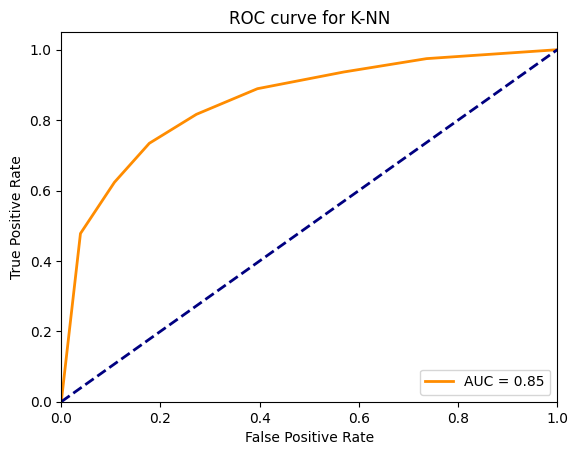

In [43]:
# draw roc curve and calculate auc
y_pred_proba = knn.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for K-NN')
plt.legend(loc='lower right')
plt.show()
